# Solving Single Decisions

## The "Party Problem" "object oriented" example

Using python classes `BN` and `Potential`

JMA 3 Apr 2025

In [1]:
# Import Bayes network classes

import Potential as P
import BN


In [2]:
# Imports from the python standard library
import math, re, os, sys 
from pathlib import Path
import itertools            # to flatten lists

# Import array and dataframe packages
import numpy as np
# import numpy.linalg as la
import pandas as pd
import torch

import networkx as nx

# Use to parse xdsl files
import xml.etree.ElementTree as et

from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sn 
# Import the bokeh python wrappers for javascript plots
#  - a preferred visualization tool
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, VBar, Span
from bokeh.io import output_notebook
output_notebook()

NETWORK_FILE = 'PartyProblem_asym.xdsl' # 'PartyProblem_asym.xdsl'  # 

Loading BokehJS ...

In [4]:
##  Walk the xdsl elements of a network
# def extract_net(xdsl_file):
#     '''Finds the first element under the top level that contains a list of nodes,
#     and returns a dict of node element objects.'''
#     tree = et.parse(xdsl_file)
#     root = tree.getroot()
#     # BN structure is contained under the node element
#     node_tree = root.findall('nodes')[0]
#     print(f'found {node_tree.tag}')
#     extensions = root.find('extensions')
#     extensions_tree = extensions.find('genie')
#     node_extensions = extensions_tree.findall('node')
#     return  list(node_tree), list(node_extensions)
    
# BN structure is contained under the node branch
parsed = BN.extract_net(NETWORK_FILE)
nodes, extensions = parsed
# tags tell the node type. 
[( k.get('id'), k.tag) for k in nodes]

found nodes


[('Party_location', 'decision'),
 ('Weather', 'cpt'),
 ('Preferences', 'utility'),
 ('Utility', 'maux'),
 ('Adjustor', 'cpt'),
 ('Detector', 'cpt')]

In [5]:
# view the XML of an element
# CPT contents are stored in row major order (first row, second row, ...)
# Parents are the first matrix dimension -- matrix is Row Markov
# et.dump(
parsed
     # nodes[2])

([<Element 'decision' at 0x15a16a2a0>,
  <Element 'cpt' at 0x15a16a930>,
  <Element 'utility' at 0x15a16aa70>,
  <Element 'maux' at 0x15a16ab60>,
  <Element 'cpt' at 0x15a16aca0>,
  <Element 'cpt' at 0x15a16ade0>],
 [<Element 'node' at 0x15a16b1f0>,
  <Element 'node' at 0x15a16b3d0>,
  <Element 'node' at 0x15a16b5b0>,
  <Element 'node' at 0x15a16b830>,
  <Element 'node' at 0x15a16ba10>,
  <Element 'node' at 0x15a16bbf0>])

## Bayes networks object

It contains 

- the parse of the network as a dictionary with node names as keys
- The graph object showing network structure
- Potential objects for computation. 



In [ ]:
# CPT parent order
# Dimensions are stored in matrix dimension order. 
[et.dump(n) for n in nodes]


<decision id="Party_location">
			<state id="Outdoors" />
			<state id="Porch" />
			<state id="Indoors" />
		</decision>
		
<cpt id="Weather">
			<state id="Sunshine" />
			<state id="Rain" />
			<probabilities>0.4 0.6</probabilities>
		</cpt>
		
<utility id="Preferences">
			<parents>Weather Party_location</parents>
			<utilities>100 90 40 0 20 50</utilities>
		</utility>
		
<maux id="Utility">
			<parents>Preferences</parents>
			<expression>4/3*(1-0.5^(Preferences/50))</expression>
		</maux>
		
<cpt id="Adjustor">
			<state id="absent" />
			<state id="ppresent" />
			<probabilities>0.1 0.9000000000000001</probabilities>
		</cpt>
		
<cpt id="Detector">
			<state id="SaySun" />
			<state id="SayRain" />
			<parents>Weather Adjustor</parents>
			<probabilities>0.51 0.49 0.87 0.13 0.48 0.52 0.4000000000000001 0.6</probabilities>
		</cpt>
	


[None, None, None, None, None, None]

### Include state and variable names to tensor dimensions

In [ ]:
# Parsing routines
bn = BN.reap(parsed)
bn.n_dict

Edges:  [('Weather', 'Preferences'), ('Party_location', 'Preferences'), ('Preferences', 'Utility'), ('Weather', 'Detector'), ('Adjustor', 'Detector')] 



{'Party_location': {'kind': 'decision',
  'parents': [],
  'states': ['Outdoors', 'Porch', 'Indoors'],
  'position': [245, 268, 324, 324]},
 'Weather': {'kind': 'cpt',
  'parents': [],
  'states': ['Sunshine', 'Rain'],
  'potential': OrderedDict({'Weather': 2})
  	tensor([0.4000, 0.6000]),
  'position': [298, 119, 408, 174]},
 'Preferences': {'kind': 'utility',
  'parents': ['Weather', 'Party_location'],
  'states': ['utility'],
  'potential': OrderedDict({'Preferences': 1, 'Weather': 2, 'Party_location': 3})
  	tensor([[[100.,  90.,  40.],
           [  0.,  20.,  50.]]]),
  'position': [435, 281, 573, 329]},
 'Utility': {'kind': 'maux',
  'parents': ['Preferences'],
  'position': [660, 279, 746, 327]},
 'Adjustor': {'kind': 'cpt',
  'parents': [],
  'states': ['absent', 'ppresent'],
  'potential': OrderedDict({'Adjustor': 2})
  	tensor([0.1000, 0.9000]),
  'position': [62, 81, 174, 116]},
 'Detector': {'kind': 'cpt',
  'parents': ['Weather', 'Adjustor'],
  'states': ['SaySun', 'SayRa

### Add graph structure

In [ ]:
# View node parents and children
for n in bn.network:
    print(n, ': ',nx.ancestors(bn.network,n), '\t', nx.descendants(bn.network,n))


Weather :  set() 	 {'Preferences', 'Detector', 'Utility'}
Preferences :  {'Party_location', 'Weather'} 	 {'Utility'}
Party_location :  set() 	 {'Preferences', 'Utility'}
Utility :  {'Party_location', 'Preferences', 'Weather'} 	 set()
Detector :  {'Weather', 'Adjustor'} 	 set()
Adjustor :  set() 	 {'Detector'}


In [ ]:
# Node children and parents   TODO use tqbulate

print('Node:     {Parents},    {Children}')
for n in G:
    print(n, ': ',nx.ancestors(G,n), '\t', nx.descendants(G,n))
#     nx.nodes(G)

Node:     {Parents},    {Children}
Weather :  set() 	 {'Preferences', 'Detector', 'Utility'}
Preferences :  {'Party_location', 'Weather'} 	 {'Utility'}
Party_location :  set() 	 {'Preferences', 'Utility'}
Utility :  {'Party_location', 'Preferences', 'Weather'} 	 set()
Detector :  {'Weather', 'Adjustor'} 	 set()
Adjustor :  set() 	 {'Detector'}


In [ ]:
positions = bn.node_centers() 
positions

{'Party_location': array([ 284.5, -296. ]),
 'Weather': array([ 353. , -146.5]),
 'Preferences': array([ 504., -305.]),
 'Utility': array([ 703., -303.]),
 'Adjustor': array([118. , -98.5]),
 'Detector': array([ 165. , -202.5])}

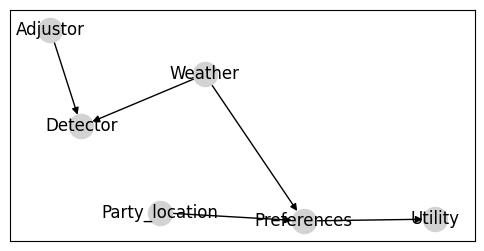

In [19]:
plt.figure(figsize=(6,3))
nx.draw_networkx_labels(bn.network, pos=positions)
nx.draw_networkx_nodes(bn.network, pos=positions, node_color='lightgrey')
nx.draw_networkx_edges(bn.network, pos=positions)

### Extract matrices as tensors.  _List all tensors_

In [20]:
# See p. 270, Howard & Abbas
# P( detector | weather)

bn.pr_named_tensors()

Weather 
	 OrderedDict({'Weather': 2})
	tensor([0.4000, 0.6000]) 

Preferences 
	 OrderedDict({'Preferences': 1, 'Weather': 2, 'Party_location': 3})
	tensor([[[100.,  90.,  40.],
         [  0.,  20.,  50.]]]) 

Adjustor 
	 OrderedDict({'Adjustor': 2})
	tensor([0.1000, 0.9000]) 

Detector 
	 OrderedDict({'Detector': 2, 'Weather': 2, 'Adjustor': 2})
	tensor([[[0.5100, 0.4900],
         [0.8700, 0.1300]],

        [[0.4800, 0.5200],
         [0.4000, 0.6000]]]) 



In [22]:
# Format one-dim tensors 
bn.one_dim_table(bn.get_potential('Weather').p, 
                 'Weather', 
                 tablefmt= '.4f', 
                 headers= ['State', 'Value'])

 *** Weather ***
State       Value
--------  -------
Sunshine      0.4
Rain          0.6


In [ ]:
## For joining by aligning potentials as named tensors
## TODO - make these methods in Potential
from collections import OrderedDict

def dim_index(potential_cpt, candidate):
    # Starting with 0 as the first location, so the last location equals the length of the shape
    cpt_dims = potential_cpt.dim_names
    # if its included is it not already last?
    if candidate in cpt_dims and candidate != list(cpt_dims)[-1]:
        return list(cpt_dims).index(candidate) 
    else:
        # Either candidate not found or its already at the end, so do nothing.
        return None

def move_named_dim_to_end(the_named_tensor, the_dimension):
    'Transpose the potential place the dimension last'
    the_dim_index = dim_index(the_named_tensor, the_dimension)
    if the_dim_index is not None:
        # Create a modified shape OrderedDict
        shape = the_named_tensor.shape.copy()
        shape.move_to_end(the_dimension)
        # Rotate the tensor dimensions
        p_transpose = list(range(len(shape)))               # The unperturbed list
        p_transpose.append(p_transpose.pop(the_dim_index))  # Move index to end
        # Transpose CPT
        x = the_named_tensor.p.permute(p_transpose)
        return P.Potential(x, shape)
    else:
        # A no op
        return the_named_tensor 
    
def marginalize_last(p1, p2):
    '''For a potential matching the last dimension of the other, join them,
    then marginalized out the last dimension'''
    if list(p1.shape)[-1] != list(p2.shape)[-1]:           # Compare shapes by indexed value
        print(f'Err, last shapes do not match:\t{list(p1.shape)[-1]} != {list(p2.shape)[-1]}')
        return None
    else:
        new_tensor = (p1.p * p2.p).sum(-1)
        # The symmetric set difference - those not common to both. 
        s1 = set(p1.shape.items())
        s2 = set(p2.shape.items())
        new_shape = OrderedDict(s1.union(s2) - s1.intersection(s2))
    return P.Potential(new_tensor, new_shape)

def marginalize(child_potential, parent_potential):
    cpt = (child_potential.p * parent_potential.p).sum(-1)
    # TODO remove parent shape from child
    sh = OrderedDict(set(child_potential.shape.items()) - set(parent_potential.shape.items()))
    return P.Potential(cpt, sh)

def shift_to_end(the_shape, the_var):
    the_shape.move_to_end(the_var)
    return the_shape

def join_parent(the_conditional, the_parent, name_dict= bn):
    'Assume the parent rv is the last dim in the conditional, and marginalize out that dim'
    # Find the parent and transpose it to last dim
    c_potential = bn.get_potential(the_conditional)
    p_potential = bn.get_potential(the_parent)
    found_dim = dim_index(c_potential,the_parent)
    # Is found dim not already in the last dim? 
    new_shape = c_potential.shape
    if found_dim is not None:   # TODO does this work if the found dim is first?
        # Move found_dim to last dimension
        new_shape = shift_to_end(new_shape, the_parent)
        c_transpose = list(range(len(new_shape)))
        c_transpose.append(c_transpose.pop(found_dim))
        # Transpose CPT
        c_potential.p.permute(c_transpose)
        # TODO - create a new potential? 
    new_joint =  P.Potential(c_potential.p * p_potential.p, new_shape)
    return new_joint

# No problem with mapping single arg functions over tensors!  
def delta_utility(x, exponand = 0.5, normalize = 50):
    dims = x.shape
    u = 4/3*(1 - pow(exponand, (x.p/normalize)))
    return P.Potential(u, dims)

### Utilities

In [47]:
# Utility matrix, as a Potential
outcome_potential = bn.get_potential('Preferences')
outcome_potential

OrderedDict({'Preferences': 1, 'Weather': 2, 'Party_location': 3})
	tensor([[[100.,  90.,  40.],
         [  0.,  20.,  50.]]])

In [48]:
# Apply a utility function by mapping it over the value tensor
u = delta_utility(outcome_potential)
u

OrderedDict({'Preferences': 1, 'Weather': 2, 'Party_location': 3})
	tensor([[[1.0000, 0.9504, 0.5675],
         [0.0000, 0.3229, 0.6667]]])

## Solving the party problem

To determine the optimal policy

* join Detector and Weather CPTs 
* join DW with Utility (Decision is implicit in Utility, w/ unit values for all options)
* marginalize out unobserved Weather (or do this after decn, to get VOI)
* Maximize over options

### First solution - only prior, no observation 

In [49]:
# Note that marginalize_last is symmetric in its arguments. 
preference_transpose = move_named_dim_to_end(bn.get_potential("Preferences"), "Weather")
preference_transpose


OrderedDict({'Preferences': 1, 'Party_location': 3, 'Weather': 2})
	tensor([[[100.,   0.],
         [ 90.,  20.],
         [ 40.,  50.]]])

In [50]:
prior_utility = marginalize_last(preference_transpose, bn.get_potential("Weather"))
bn.one_dim_table(prior_utility.p, 'Party_location') 

 *** Party_location ***
--------  --
Outdoors  40
Porch     48
Indoors   46
--------  --


In [51]:
# return the joint potential, with the conditioning prob last. 
dw_joint = join_parent("Detector", 'Weather')
dw_joint


OrderedDict({'Detector': 2, 'Adjustor': 2, 'Weather': 2})
	tensor([[[0.2040, 0.2940],
         [0.3480, 0.0780]],

        [[0.1920, 0.3120],
         [0.1600, 0.3600]]])

In [52]:
# P( Weather | Detector) - column markov
# See p 270 Figure 13.6
#   Transpose the joint to get the Detector in last dim, and normalize 
pre_posterior_p = dw_joint.p.sum(-1) 
p = dw_joint.p.transpose(0,1) * (1/pre_posterior_p)
# reverse the shape 
posterior = P.Potential(p, OrderedDict(list(reversed(dw_joint.shape.items()))) )
print('>>> pre_posterior <<<\n',pre_posterior_p, '\n>>> posterior <<<\n', posterior)



>>> pre_posterior <<<
 tensor([[0.4980, 0.4260],
        [0.5040, 0.5200]]) 
>>> posterior <<<
 OrderedDict({'Weather': 2, 'Adjustor': 2, 'Detector': 2})
	tensor([[[0.4096, 0.6901],
         [0.3810, 0.6000]],

        [[0.6988, 0.1831],
         [0.3175, 0.6923]]])


In [53]:
# One approach is to add a unsqueeze(es) dim to match Detector at the end of preference transpose
# BINGO
extended_preference = preference_transpose.p.unsqueeze(-1).unsqueeze(-1)
# print(extended_preference.shape)
# Sum out the weather dimension
policy_values = (extended_preference * posterior.p).sum(2)
print('E[ V | Party_location, Detector] = ')
policy_values
# Next we need to weight the optimal in each column by the pre-posterior.

E[ V | Party_location, Detector] = 


tensor([[[[40.9639, 69.0141],
          [38.0952, 60.0000]],

         [[50.8434, 65.7746],
          [40.6349, 67.8461]],

         [[51.3253, 36.7606],
          [31.1111, 58.6154]]]])

In [54]:
# TODO Need to format list entries before passing to tabulate. 
# TODO looks like the State labels are flipped. 
detector_states= bn.n_dict['Detector']['states'].copy()
detector_states.insert(0, 'State')
bn.one_dim_table(policy_values.squeeze(0), 
    'Party_location', 
    floatfmt= ".3f", 
    headers= detector_states)
        

 *** Party_location ***
State     SaySun                                  SayRain
--------  --------------------------------------  ----------------------------------------
Outdoors  [40.96385192871094, 69.01408386230469]  [38.095237731933594, 59.999996185302734]
Porch     [50.84336853027344, 65.77464294433594]  [40.634918212890625, 67.84614562988281]
Indoors   [51.32529830932617, 36.76055908203125]  [31.11111068725586, 58.615379333496094]


<Axes: >

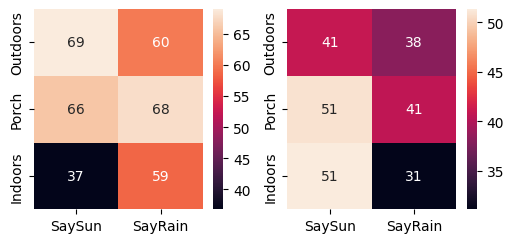

In [55]:
# what is the last dim?  Need to remove it. 
fig, ax = plt.subplots(1,2, figsize = (6, 2.6))
policy_values_2d_a = pd.DataFrame(policy_values.squeeze(0)[:,:,1], columns = bn.n_dict['Detector']['states'], 
                                index = bn.n_dict['Party_location']['states'])
sn.heatmap(policy_values_2d_a, annot=True, xticklabels=True, yticklabels=True, ax=ax[0])
policy_values_2d_b = pd.DataFrame(policy_values.squeeze(0)[:,:,0], columns = bn.n_dict['Detector']['states'], 
                                index = bn.n_dict['Party_location']['states'])
sn.heatmap(policy_values_2d_b, annot=True, xticklabels=True, yticklabels=True, ax=ax[1])

In [56]:
# Find the policy as the max value in each column. 
decn = policy_values.max(1)
# Which entry is that in the column?
decn.values, decn.indices

(tensor([[[51.3253, 69.0141],
          [40.6349, 67.8461]]]),
 tensor([[[2, 0],
          [1, 1]]]))

In [57]:
# Value with information. 
# However utility should be applied after computing expected values to get certain equivalents
# sigh
# 0.7782 * 0.44 + 0.6557 * 0.56
decn.values @ bn.get_potential('Weather').p

tensor([[61.9386, 56.9617]])